In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

# Import Tools and Dependencies

In [2]:
import pandas as pd 
import numpy as np 
import os 
import tensorflow as tf
from tqdm import tqdm

# NLP Imports 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding , LSTM , add ,Input,Dense, Concatenate, Reshape , concatenate , Bidirectional,Dropout

# Model Creation Imports 
from tensorflow.keras.models import Sequential , Model

#Computer vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.applications import DenseNet201

#Model Learning and Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau

#Warnings & Visiualization 
import warnings 
import matplotlib.pyplot as plt 
import seaborn as sns 
from textwrap import wrap

plt.rcParams["font.size"] = 12
sns.set_style("dark")
warnings.filterwarnings("ignore")

2025-10-30 05:36:33.414911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761802593.619349      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761802593.685587      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [3]:
image_path = "/kaggle/input/flickr8k/Images"
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")

In [4]:
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Display th Images

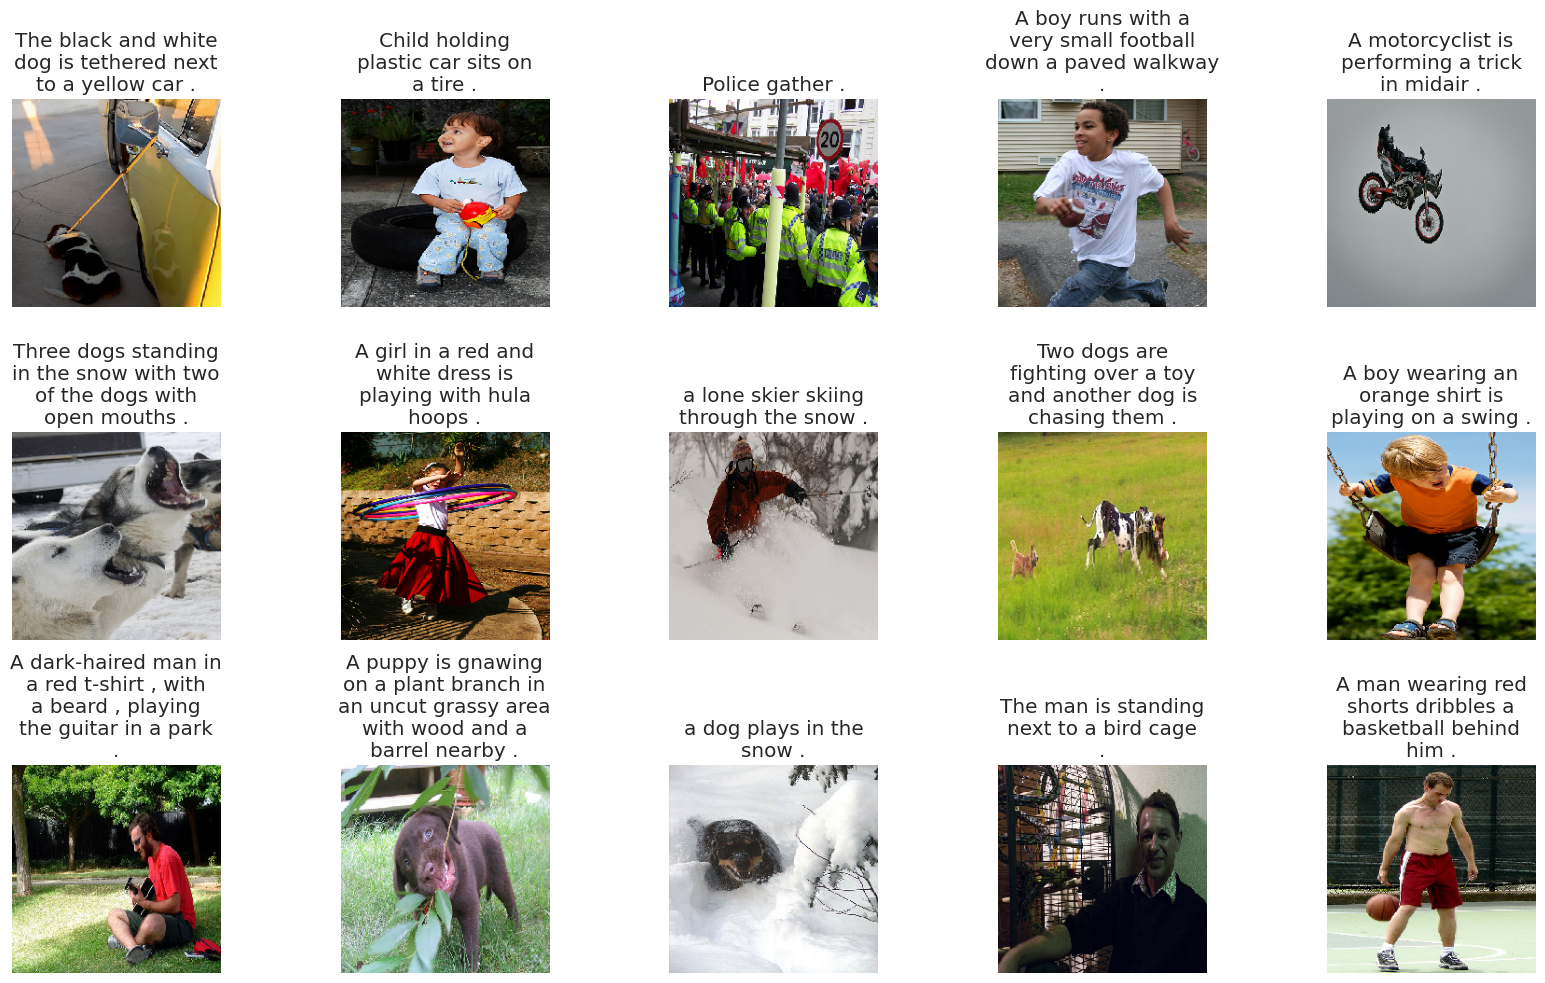

In [5]:
def LoadImage(path , img_size=224):
    img = load_img(path , color_mode="rgb" , target_size = (img_size , img_size))
    img = img_to_array(img)
    img = img/255 #normalization to binary image

    return img




def display_image(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n=n+1
        plt.subplot(5 ,5 ,n)
        plt.subplots_adjust(hspace = 0.6 , wspace=0.4)
        image = LoadImage(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i] , 20)))
        plt.axis("off")

display_image(data.sample(15))
    

# Captions Text Preprocessing
1. lowercasing
2. Remove special charcters and numbers
3. Remove extra spaces
4. Remove single characters
5. Add a starting and ending tag to the sentences to indicate the beginning and the ending of a sentence

In [6]:
def text_preprocessing(data):
    data["caption"] = data["caption"].apply(lambda x : x.lower())
    data["caption"] = data["caption"].apply(lambda x : x.replace("[^A-Za-z]" , ""))
    data["caption"] = data["caption"].apply(lambda x : x.replace("\s+" , " "))
    data["caption"] = data["caption"].apply(lambda x : " ".join([word for word in x.split() if len(word)>1]))
    data["caption"] = "startseq " + data["caption"] + " endseq"

    return data
    
data = text_preprocessing(data)
captions = data["caption"].tolist()
captions[1:6]


['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq']

# Tokenization
- coverting text to vectors

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

#finding the total number of words as a whole
vocab_size = len(tokenizer.word_index) +1

#finding the length of the max sentence for padding or truncation
max_length = max([len(caption.split()) for caption in captions])

#extracting the image data
images = data["image"].unique().tolist()
nimages = len(images)

#train test split 
split_index =round(0.85 * nimages)

# separatig train and val images 
train_images = images[:split_index]
val_images = images[split_index:]


# Making Train and Test datasets
train = data[data["image"].isin(train_images)]
test = data[data["image"].isin(val_images)]

#rest the index of train and test sets
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True , drop = True)

tokenizer.texts_to_sequences([captions[1]])[0] #as [captions[0]] returns a 2D array



[1, 18, 315, 63, 195, 116, 2]

# Image Feature Extraction
Here we are using DenseNet201 Architecture to extract the features from the images


In [8]:
model = DenseNet201() # pretrained model help us automatically extract features from the images
fe = Model(inputs = model.input , outputs = model.layers[-2].output) #feature extractor

img_size = 224
features = {}

for image in tqdm(data["image"].unique().tolist()):
    img = load_img(os.path.join(image_path , image) , target_size =(img_size , img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img , axis=0)
    feature = fe.predict(img , verbose = 0)
    features[image] = feature


I0000 00:00:1761802610.685659      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1761802628.895663      63 service.cc:148] XLA service 0x7e58a0001680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761802628.896639      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761802631.034849      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761802643.999199      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [15:02<00:00,  8.96it/s]


# Data Generation
* Since image caption model's training is like any other neural network training is a highly resource utilizing process we cannot load the data into the hence we need to generate the data in the required format batch size
* The inputs will be the image embeddings and their corresponding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during the inference time.

In [9]:
# Resizing , rotating the images(data generator or data augmentation)
# We can do data generation by using the keras built in class dependig on the probelm .
# In this case , we are using NLP and Computer vision both , thus creating our own custom class for this task.

class CustomDataGenerator(Sequence):
    def __init__(self ,
                 df,
                 X_col ,
                 y_col ,
                 batch_size ,
                 directory ,
                 tokenizer ,
                 vocab_size ,
                 max_length ,
                 features ,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col 
        self.y_col = y_col 
        self.directory = directory
        self.batch_size =batch_size
        self.tokenizer = tokenizer 
        self.max_length = max_length 
        self.features = features
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop = True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self , index):
        batch = self.df.iloc[index * self.batch_size : (index +1) * self.batch_size,:]
        X1 , X2 , y = self.__get_data(batch)
        return (X1 , X2) , y


    def __get_data(self , batch):
        X1,X2,y = list(),list(),list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image , self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1 , len(seq)):
                    in_seq , out_seq = seq[:i] , seq[i]
                    in_seq = pad_sequences([in_seq] , maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq] , num_classes = self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        
        X1 , X2 , y = np.array(X1) , np.array(X2) , np.array(y)
        return X1 , X2 , y
             
train_generator = CustomDataGenerator(df = train , X_col = "image" , y_col = "caption" , batch_size = 64 , directory = image_path ,                                  tokenizer = tokenizer , vocab_size = vocab_size , max_length = max_length , features = features)

validation_generator = CustomDataGenerator(df = test , X_col = "image" , y_col = "caption" , batch_size = 64 , directory = image_path,
                                          tokenizer = tokenizer , vocab_size = vocab_size , max_length = max_length , features = features)

In [10]:
# sit row train_generator
train_generator[0]

((array([[7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         ...,
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

# Modelling:
1. the image embedding representations are concatenated with the first word of the sentence i.e starseq and passed to the LSTM network
2. The LSTM network starts generating word after each input thus forming a sentence at the end
   

In [11]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,)) #input for image
input2 = Input(shape=(max_length,)) #input for toeknized captions

#for input1(images)
img_features = Dense(256 , activation = "relu")(input1)
img_features_reshaped = Reshape((1 , 256), input_shape=(256,))(img_features)

#for input2(captions)(Embedding convert word to vectors)
sentence_features = Embedding(vocab_size,256 , mask_zero = False)(input2)

#combining the both type of input features
merged = concatenate([img_features_reshaped , sentence_features] , axis = 1)
sentence_features = LSTM(256)(merged) # here reduce the dimension to 256 and model is stored in sentence features variable

#To reduce overfitting during training , using Dropout layer 
x = Dropout(0.5)(sentence_features)
x = add([x , img_features])

x = Dense(128 , activation = "relu")(x)
x = Dropout(0.5)(x)

output = Dense(vocab_size , activation = "softmax")(x)

caption_model = Model(inputs = [input1, input2] , outputs = output)
caption_model.compile(loss = "categorical_crossentropy" , optimizer = "adam")

#during training i want to save the best model dynamically
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name ,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True , 
    save_weights_only = False , 
    verbose = 1
)

earlystopping = EarlyStopping(monitor = "val_loss" , patience = 5 , restore_best_weights = True) #stop training if validation loss is not decreasing afetr some epochs. patience = 5 means wait for next 5 epochs and then stop training
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss" , patience = 3 , factor = 0.2 , min_lr = 1e-8) #don't change the lr if validation loss is not decreasing from last 3 epochs



In [12]:
#Training the model
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data = validation_generator,
    callbacks = [checkpoint , earlystopping , learning_rate_reduction] 
)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 5.7084
Epoch 1: val_loss improved from inf to 4.29638, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 81s 142ms/step - loss: 5.7072 - val_loss: 4.2964 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.3391
Epoch 2: val_loss improved from 4.29638 to 3.98256, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 4.3389 - val_loss: 3.9826 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.0277
Epoch 3: val_loss improved from 3.98256 to 3.81669, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.0277 - val_loss: 3.8167 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.8345
Epoch 4: val_loss improved from 3.81669 to 3.72959, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 3.8344 - val_loss: 3.7296 - learning_rate: 0.0010


# Learning Curve
1. The model has clearly overfit , possibly due to the less amount of data
2. We can tackle this problem in two ways
   1. Train the model on larger dataset Flikr40k
   2. Attention Models



In [13]:
history.history

{'loss': [5.090923309326172,
  4.2686309814453125,
  3.9986116886138916,
  3.8235020637512207,
  3.697422742843628,
  3.600754976272583,
  3.516009569168091,
  3.448146343231201,
  3.388155698776245,
  3.334932327270508,
  3.2880563735961914,
  3.2447052001953125,
  3.1408281326293945,
  3.1153857707977295],
 'val_loss': [4.296378135681152,
  3.9825611114501953,
  3.816685914993286,
  3.729586362838745,
  3.673083543777466,
  3.643986940383911,
  3.633655071258545,
  3.6187021732330322,
  3.6146833896636963,
  3.616530656814575,
  3.636255979537964,
  3.6404659748077393,
  3.656419038772583,
  3.646812677383423],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00020000000949949026,
  0.00020000000949949026]}

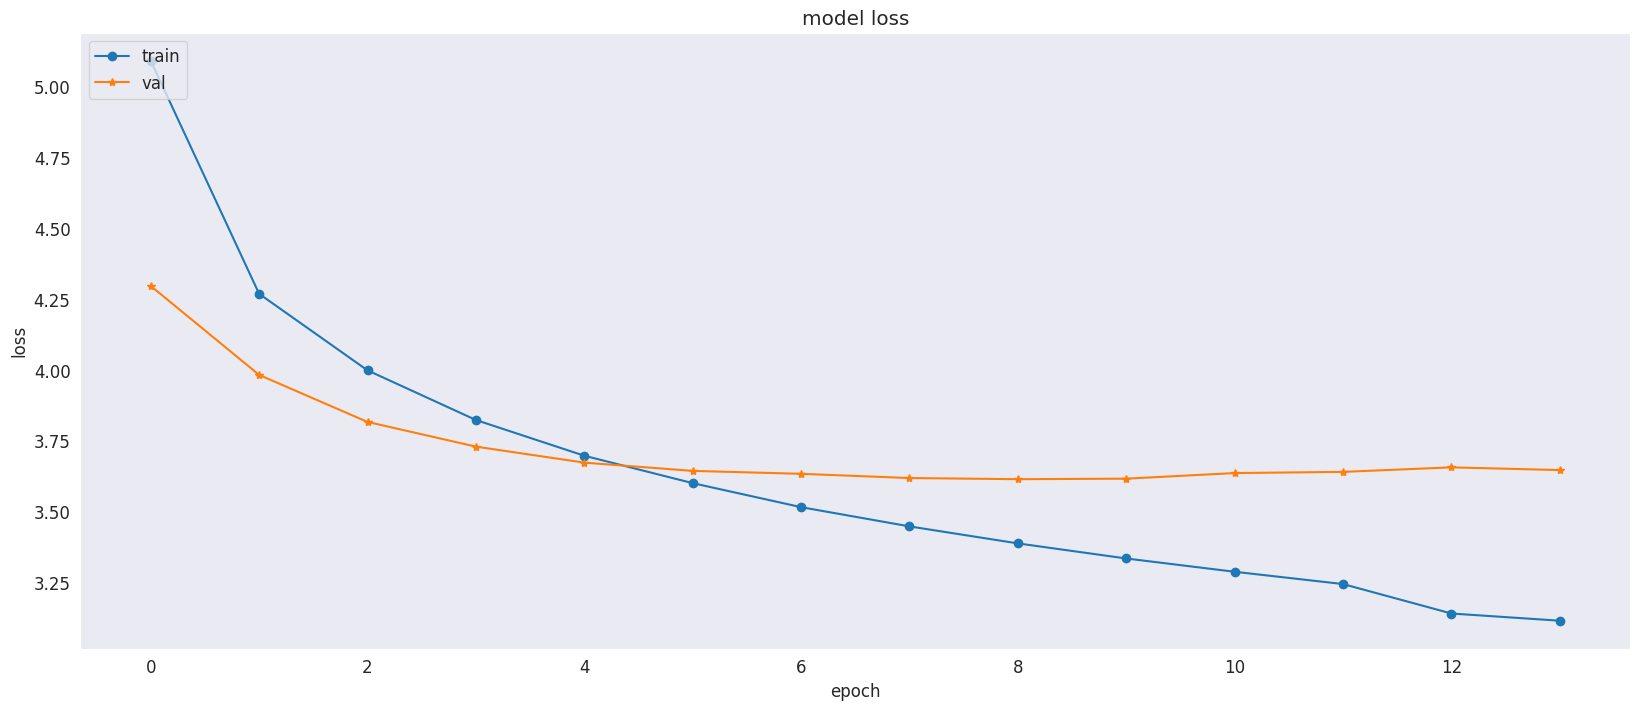

In [14]:
plt.figure(figsize = (20 , 8))
plt.plot(history.history["loss"] , marker = "o")
plt.plot(history.history["val_loss"] , marker = "*")
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train" , "val"] , loc = "upper left")
plt.show()

# Real Time Image Captioning System (Caption Generating Utility Functions)

1. This function will generate the cations for the input images during the inference time
2. Here the image embeddings are passed along with the first word , followed by which the text embedding of each new word

In [15]:
import pickle 
#save the tokenizer 
with open("tokenizer.pkl" , "wb") as f:
    pickle.dump(tokenizer,f)

#Save the feature extractor model 
fe.save("feature_extractor.keras")


In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

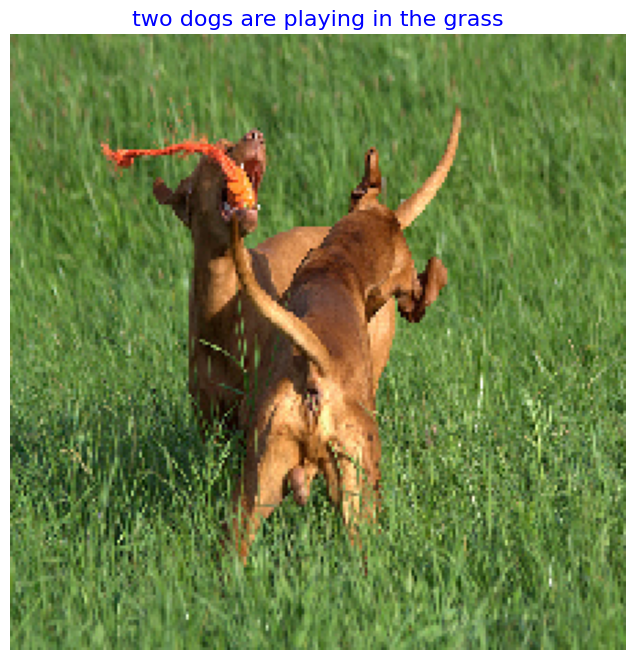

In [17]:
#Example usage
image_path = "/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg"
generate_and_display_caption(image_path  , model_path , tokenizer_path , feature_extractor_path)

In [18]:
# /kaggle/input/flickr8k/Images/3758787457_1a903ee1e9.jpg
# /kaggle/input/flickr8k/Images/2267682214_e1434d853b.jpg
# /kaggle/input/flickr8k/Images/488356951_b3b77ad832.jpg
# /kaggle/input/flickr8k/Images/3439560988_f001f96fc9.jpg

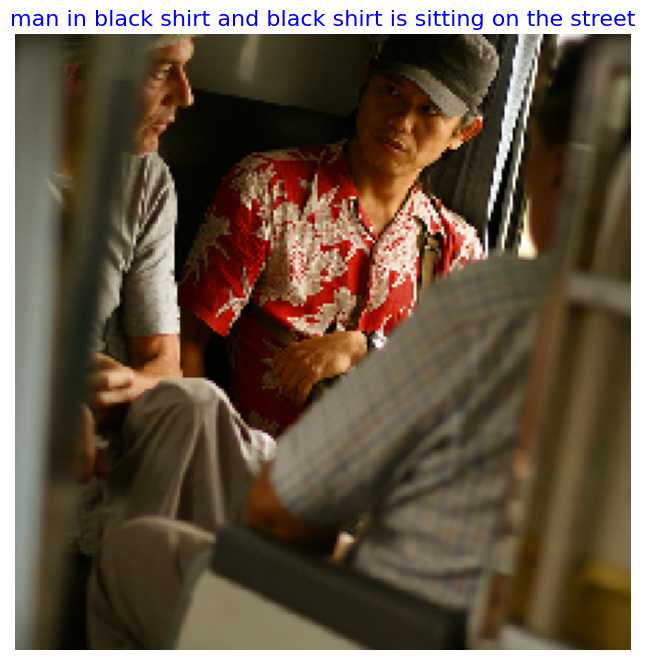

In [19]:
#Example2 usage
image_path = "/kaggle/input/flickr8k/Images/488356951_b3b77ad832.jpg"
generate_and_display_caption(image_path  , model_path , tokenizer_path , feature_extractor_path)